# Sobel vs Adaptive Sobel

## Matrik Evaluasi

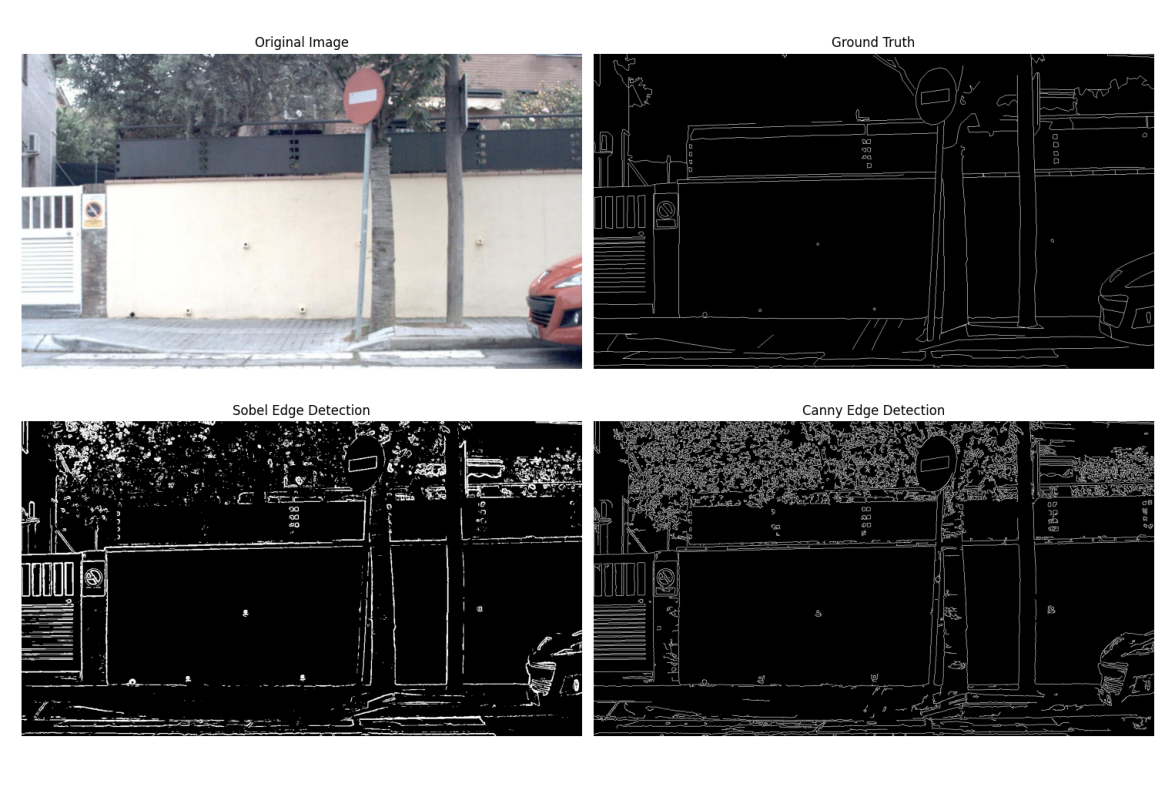

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Membaca gambar
img = mpimg.imread('./assets/compar/comparison_RGB_113.png')

# Menampilkan gambar
plt.figure(figsize=(20, 10)) 
plt.imshow(img)
plt.axis('off')  # Menonaktifkan sumbu
plt.show()

## Gimana Ngukurnya Itu Bagus apa Engga?

kalo dari visual kadang kita gabisa lihat, karena memang ada perhitungan khususnya yang bikin lebih akurat pengukurannya

### Matriks Evaluasi

Ketika kita buat sistem deteksi tepi, misalnya untuk mendeteksi batas atau transisi antara objek dan latar belakang dalam gambar, kita mau tau seberapa baik sistem tersebut bekerja. Apakah metode itu mengenali tepi dengan baik? Apakah metode itu ada banyak kesalahan? Metrik evaluasi inilah yang digunakan untuk mengukur performa dari metode kita.

ada beberapa metode untuk ngukurnya

- PSNR dan SSIM: Gambar asli vs gambar yang diproses oleh Metode. Seberapa mirip keduanya?

- Precision dan Recall: Untuk pendeteksian tepi, seberapa banyak tepi yang benar-benar terdeteksi dan seberapa banyak yang hilang?

- F1 Score: Kombinasi keduanya, precision dan recall, untuk memberikan gambaran lengkap tentang performa sistem.

Of course kita perlu look up to nya, yaa, semacam labelnya. nah disini biasanya orang itu pake ground truth, sistemnya ada gambar asli, terus orang gabut ini ngedeteksi sendiri dengan sangat hati hati tepinya. itu lah yang paling akurat untuk definisiin tepi dari gambar itu. nah sekarang kita cuma perlu masukin gambar itu ke metode kita, dan hasilnya akan dibandingkan dengan ground truth, yaitu edge yang sebenarnya dan seharusnya. dari situ kita bisa dapet error untuk ngitung matriks evaluasi tadi.


PNSR :

Peak Signal to Noise Ratio, simple nya gambar label yang seharusnya itu dibandingin sama gambar hasil metode kita, disitu bakal kehitung perbedaannya atau error atau kalo disini noise, semakin kecil error ya berarti semakin mirip. which is semakin bagus berarti ngedeteksinya.

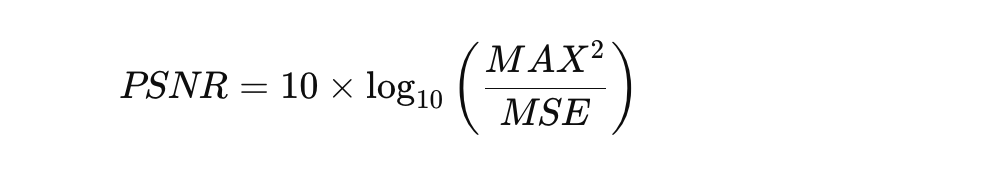

rumusnya simple, kita mau bandingin nilai maksimal piksel dengan errornya yang pake mean square error.log disini buat ngukur nya, semakin besar perbedaan errornya maka semakin kecil nilai PNSR ini, nah kalo MSE itu nilainya kecil which is error nya kecil, maka kalo di log in akan besar, jadi hasil PNSR semakin besar mengindikasikan model itu semakin baik untuk deteksi karena hampir sama kayak look upnya.

SSI :

Structural Similarity Index , ini lebih advance, dia ga cuma bedain nilai piksel tapi juga kontras luminance dan teksturnya. 


Precision :

precision sesuai namanya ngedeteksi seberapa akurat deteksi tepi, caranya?. misal kita deteksi banyak tepi, terus dibandingin, berapa banyak yang benar benar ada. precision itu ngasih tau kita seberapa banyak kita salah deteksi tepi (false positive). apakah ini betul betul ada atau gimana, kalo dideteksi tapi sebenarnya gaada, berarti yang kedeteksi itu ga relevan, disini kita bisa nilai model kita banyak salah deteksi tepi. semakin tinggi nilainya semakin bagus, berarti semakin rendah tepi yang ga relevan. analoginya detektif cari bukti, tapi apakah bukti itu relevan?

Recall :

kebalikannya false negative, seberapa banyak tepi yang seharusnya ada tapi kelewat dideteksi, artinya ada banyak tepi yang masih terlewat model kita untuk deteksi. sama juga, semakin tinggi semakin bagus, berarti semakin kecil tidak terdeteksi, artinya kedeteksi semua. analoginya detektif cari bukti, tapi beberapa bukti itu hilang.

F1 Score :

gabungan keduanya, false positive, seberapa banyak tepi yang ga relevan dan false negative, seberapa banyak tepi yang kelewat. akan ada dua kemungkinan disini, 

- precision besar atau semakin akurat deteksi yang relevan, sedangkan recall kecil atau banyak tepi yang kelewat.
- precision rendah atau semakin banyak yang ga relevan kedeteksi, dan recall tinggi atau ga banyak tepi yang kelewat.

Rumusnya ajaib sih :

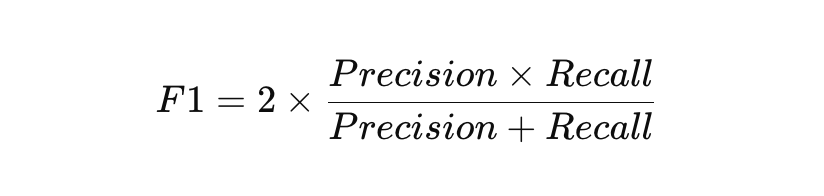

dengan begini keduanya harus seimbang, harus sama sama tinggi untuk dapetin nilai f score yang tinggi, yang artinya precision tinggi mengindikasikan tidak ada data irrelevan yang terdeteksi dan recall tinggi yang mingindikasikan semua tepi terdeteksi dengan baik tanpa kelewat.

In [1]:
import os 
import cv2 
import numpy as np 
from sklearn.metrics import precision_score, recall_score, f1_score 
from skimage.metrics import structural_similarity as ssim 
from skimage.metrics import peak_signal_noise_ratio as psnr 

# === Path Dataset === 
dataset_path = "BIPED"  # Ganti dengan folder kamu 
img_folder = os.path.join(dataset_path, "imgs/train") 
gt_folder = os.path.join(dataset_path, "edge_maps/train") 

# === Helper Function === 
def apply_sobel(img_gray): 
    sobelx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=3) 
    sobely = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=3) 
    sobel = np.hypot(sobelx, sobely) 
    sobel = np.uint8(255 * sobel / np.max(sobel)) 
    return sobel 

def apply_adaptive_sobel(img_gray, block_size=11, c=2): 
    # Apply Sobel to get gradient magnitude
    sobelx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=3) 
    sobely = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=3) 
    magnitude = np.sqrt(sobelx**2 + sobely**2) 
    
    # Normalize to 0-255 range
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8) 
    
    # Apply adaptive thresholding
    adaptive_threshold = cv2.adaptiveThreshold(
        magnitude,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        block_size,
        c
    )
    
    return adaptive_threshold

def binarize(img, threshold=50): 
    _, binary = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY) 
    return binary 

def evaluate(pred, gt): 
    # Pastikan ukuran prediksi dan ground truth sama 
    if pred.shape != gt.shape: 
        gt = cv2.resize(gt, (pred.shape[1], pred.shape[0]))  # Resize ground truth ke ukuran prediksi 
    
    # Binarisasi prediksi dan ground truth (ubah ke 0 dan 1 untuk sklearn metrics)
    pred_bin = (pred > 0).astype(np.uint8)
    gt_bin = (gt > 0).astype(np.uint8)

    # Menghitung metrik evaluasi 
    precision = precision_score(gt_bin.flatten(), pred_bin.flatten(), zero_division=0) 
    recall = recall_score(gt_bin.flatten(), pred_bin.flatten(), zero_division=0) 
    f1 = f1_score(gt_bin.flatten(), pred_bin.flatten(), zero_division=0) 

    # For PSNR and SSIM, use the 0-255 range images
    pred_255 = pred_bin * 255
    gt_255 = gt_bin * 255
    
    psnr_value = psnr(gt_255, pred_255) 
    ssim_value = ssim(gt_255, pred_255) 

    return precision, recall, f1, psnr_value, ssim_value 

# === Main Loop === 
results_sobel = [] 
results_adaptive = [] 

# Parameters for adaptive Sobel
block_size = 11  # Must be odd
c_value = 2

# Count processed images
processed_count = 0

print("Starting evaluation...")

for img_name in os.listdir(img_folder): 
    if img_name.endswith((".jpg", ".jpeg", ".png")):  # Process all image types
        try:
            img_path = os.path.join(img_folder, img_name) 
            gt_path = os.path.join(gt_folder, os.path.splitext(img_name)[0] + ".png") 
            
            # Check if ground truth exists
            if not os.path.exists(gt_path):
                print(f"Warning: Ground truth not found for {img_name}, skipping...")
                continue

            img = cv2.imread(img_path) 
            gt = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE) 

            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Apply Sobel 
            sobel_edges = apply_sobel(img_gray) 
            sobel_edges_bin = binarize(sobel_edges) 

            # Apply Adaptive Sobel 
            adaptive_edges = apply_adaptive_sobel(img_gray, block_size, c_value) 
            
            # No need to binarize adaptive_edges as it's already binary

            # Evaluate 
            sobel_scores = evaluate(sobel_edges_bin, gt) 
            adaptive_scores = evaluate(adaptive_edges, gt) 

            results_sobel.append(sobel_scores) 
            results_adaptive.append(adaptive_scores) 
            
            processed_count += 1
            if processed_count % 10 == 0:
                print(f"Processed {processed_count} images...")
                
        except Exception as e:
            print(f"Error processing {img_name}: {str(e)}")

print(f"\nEvaluation complete. Processed {processed_count} images.")

if not results_sobel or not results_adaptive:
    print("No results to display. Check your dataset paths.")
    exit()

# === Averaging Results === 
results_sobel = np.array(results_sobel) 
results_adaptive = np.array(results_adaptive) 

print("\n=== Sobel Biasa ===") 
print(f"Precision: {results_sobel[:,0].mean():.4f}") 
print(f"Recall:    {results_sobel[:,1].mean():.4f}") 
print(f"F1 Score:  {results_sobel[:,2].mean():.4f}") 
print(f"PSNR:      {results_sobel[:,3].mean():.2f}") 
print(f"SSIM:      {results_sobel[:,4].mean():.4f}") 

print("\n=== Adaptive Sobel ===") 
print(f"Precision: {results_adaptive[:,0].mean():.4f}") 
print(f"Recall:    {results_adaptive[:,1].mean():.4f}") 
print(f"F1 Score:  {results_adaptive[:,2].mean():.4f}") 
print(f"PSNR:      {results_adaptive[:,3].mean():.2f}") 
print(f"SSIM:      {results_adaptive[:,4].mean():.4f}") 

# Calculate improvement percentages
precision_improvement = ((results_adaptive[:,0].mean() - results_sobel[:,0].mean()) / results_sobel[:,0].mean()) * 100
recall_improvement = ((results_adaptive[:,1].mean() - results_sobel[:,1].mean()) / results_sobel[:,1].mean()) * 100
f1_improvement = ((results_adaptive[:,2].mean() - results_sobel[:,2].mean()) / results_sobel[:,2].mean()) * 100
psnr_improvement = ((results_adaptive[:,3].mean() - results_sobel[:,3].mean()) / results_sobel[:,3].mean()) * 100
ssim_improvement = ((results_adaptive[:,4].mean() - results_sobel[:,4].mean()) / results_sobel[:,4].mean()) * 100

print("\n=== Improvement (Adaptive vs Regular) ===")
print(f"Precision: {precision_improvement:.2f}%")
print(f"Recall:    {recall_improvement:.2f}%")
print(f"F1 Score:  {f1_improvement:.2f}%")
print(f"PSNR:      {psnr_improvement:.2f}%")
print(f"SSIM:      {ssim_improvement:.2f}%")

Starting evaluation...
Processed 10 images...
Processed 20 images...
Processed 30 images...
Processed 40 images...
Processed 50 images...
Processed 60 images...
Processed 70 images...
Processed 80 images...
Processed 90 images...
Processed 100 images...
Processed 110 images...
Processed 120 images...
Processed 130 images...
Processed 140 images...
Processed 150 images...
Processed 160 images...
Processed 170 images...
Processed 180 images...
Processed 190 images...
Processed 200 images...

Evaluation complete. Processed 200 images.

=== Sobel Biasa ===
Precision: 0.1640
Recall:    0.4159
F1 Score:  0.2295
PSNR:      11.15
SSIM:      0.6650

=== Adaptive Sobel ===
Precision: 0.0358
Recall:    0.7019
F1 Score:  0.0678
PSNR:      2.46
SSIM:      0.0188

=== Improvement (Adaptive vs Regular) ===
Precision: -78.15%
Recall:    68.77%
F1 Score:  -70.43%
PSNR:      -77.95%
SSIM:      -97.17%


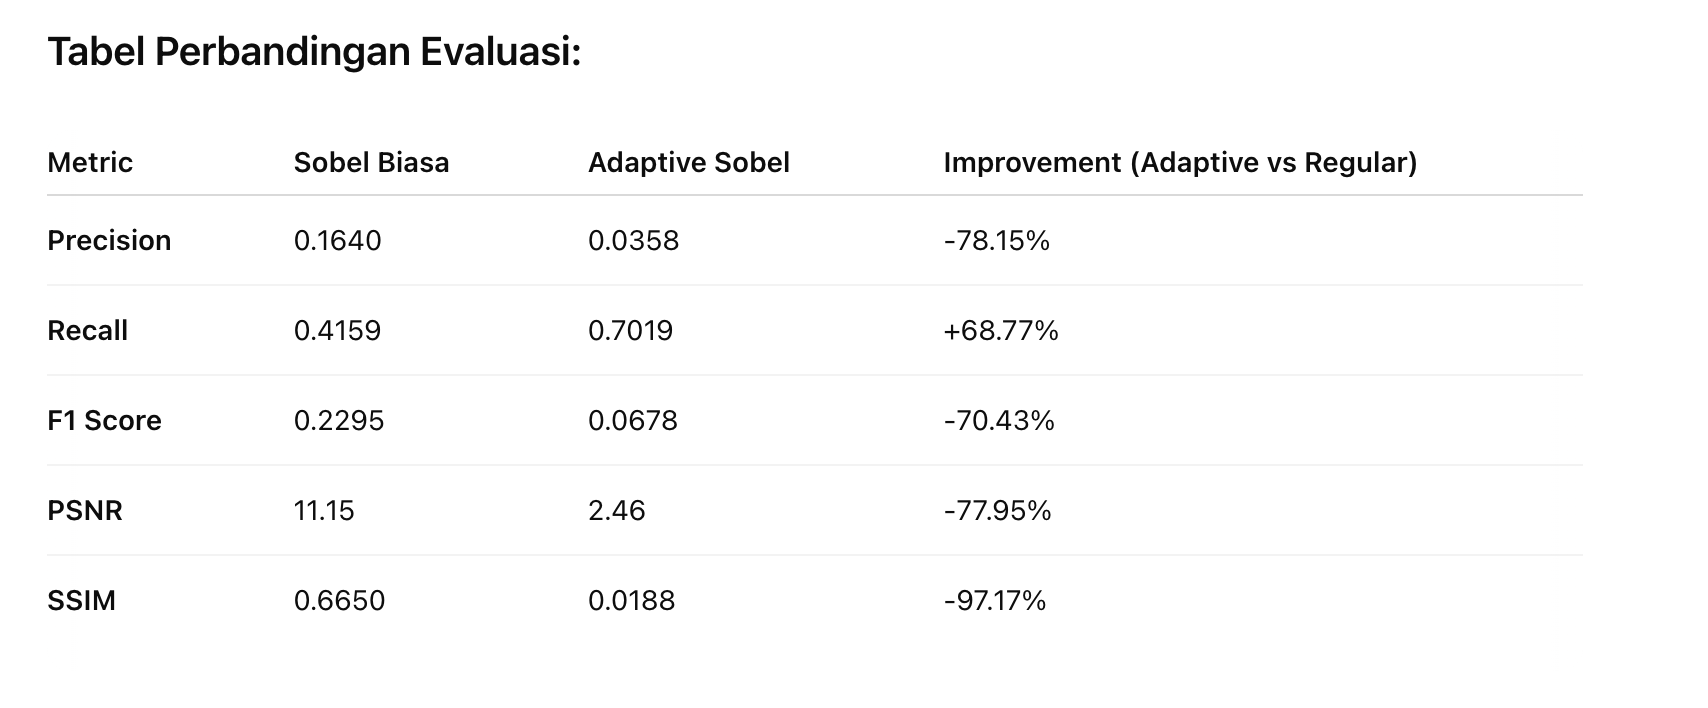


- Kesimpulan:
Hasil evaluasi menunjukkan perbandingan antara metode Sobel Biasa dan Adaptive Sobel dalam mendeteksi tepi (edge detection). Berikut adalah temuan utama:

1. Precision: Sobel Biasa memiliki nilai Precision yang jauh lebih tinggi daripada Adaptive Sobel. Ini berarti Sobel Biasa lebih akurat dalam mendeteksi tepi yang benar dibandingkan dengan Adaptive Sobel.

2. Recall: Meskipun Adaptive Sobel memiliki nilai Recall yang lebih tinggi, ini menunjukkan bahwa ia lebih sensitif dalam mendeteksi tepi, termasuk yang mungkin tidak begitu jelas.

3. F1 Score: F1 Score, yang menggabungkan Precision dan Recall, menunjukkan bahwa Sobel Biasa memiliki kinerja yang lebih baik secara keseluruhan dibandingkan Adaptive Sobel.

4. PSNR: Sobel Biasa juga menunjukkan PSNR yang lebih tinggi, yang menunjukkan kualitas gambar yang lebih baik setelah deteksi tepi.

5. SSIM: SSIM sangat rendah untuk Adaptive Sobel, menandakan bahwa hasil deteksi tepinya jauh lebih buruk dalam hal kesamaan struktural dengan ground truth.



- Interpretasi:
1. Precision yang lebih tinggi pada Sobel Biasa mengindikasikan bahwa hasil deteksi lebih tepat dalam memilih tepi yang benar.

2. Recall yang lebih tinggi pada Adaptive Sobel menunjukkan bahwa metode ini lebih mampu menemukan tepi, namun seringkali termasuk tepi yang tidak begitu relevan.

3. PSNR dan SSIM yang lebih tinggi pada Sobel Biasa menunjukkan bahwa hasilnya lebih mendekati citra asli dalam hal kualitas dan kesamaan struktural.

- Kesimpulan Umum: Meskipun Adaptive Sobel lebih sensitif terhadap tepi dan memiliki recall yang lebih tinggi, Sobel Biasa memberikan hasil yang lebih akurat dan berkualitas dalam hal precision, PSNR, dan SSIM. Oleh karena itu, Sobel Biasa lebih disarankan untuk tugas deteksi tepi yang membutuhkan ketepatan lebih tinggi.

In [26]:
import os 
import cv2 
import numpy as np 
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from skimage.metrics import structural_similarity as ssim 
from skimage.metrics import peak_signal_noise_ratio as psnr 
import matplotlib.pyplot as plt
from tqdm import tqdm

# === Path Dataset === 
dataset_path = "BIPED"  # Change to your folder 
img_folder = os.path.join(dataset_path, "imgs/train") 
gt_folder = os.path.join(dataset_path, "edge_maps/train") 

# === Helper Functions === 
def apply_sobel(img_gray):
    """Apply standard Sobel edge detection"""
    sobelx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=3) 
    sobely = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=3) 
    sobel = np.hypot(sobelx, sobely) 
    sobel = np.uint8(255 * sobel / np.max(sobel)) 
    return sobel 

def apply_canny(img_gray, low_threshold=50, high_threshold=150):
    """Apply Canny edge detection with hysteresis thresholding"""
    return cv2.Canny(img_gray, low_threshold, high_threshold)

def binarize(img, threshold=50): 
    """Convert grayscale image to binary using threshold"""
    _, binary = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY) 
    return binary 

def evaluate(pred, gt): 
    """Evaluate edge detection performance against ground truth"""
    # Ensure prediction and ground truth have same dimensions
    if pred.shape != gt.shape: 
        gt = cv2.resize(gt, (pred.shape[1], pred.shape[0]))
    
    # Binarize images (convert to 0 and 1 for sklearn metrics)
    pred_bin = (pred > 0).astype(np.uint8)
    gt_bin = (gt > 0).astype(np.uint8)

    # Calculate evaluation metrics
    precision = precision_score(gt_bin.flatten(), pred_bin.flatten(), zero_division=0) 
    recall = recall_score(gt_bin.flatten(), pred_bin.flatten(), zero_division=0) 
    f1 = f1_score(gt_bin.flatten(), pred_bin.flatten(), zero_division=0)
    accuracy = accuracy_score(gt_bin.flatten(), pred_bin.flatten())

    # For PSNR and SSIM, use the 0-255 range images
    pred_255 = pred_bin * 255
    gt_255 = gt_bin * 255
    
    psnr_value = psnr(gt_255, pred_255) 
    ssim_value = ssim(gt_255, pred_255)
    
    # Calculate boundary F1 (BF) score - approximation
    # This metric better reflects edge localization quality
    kernel = np.ones((3,3), np.uint8)
    gt_dilated = cv2.dilate(gt_bin, kernel, iterations=1)
    pred_dilated = cv2.dilate(pred_bin, kernel, iterations=1)
    
    # True positives considering boundary tolerance
    tp_boundary = np.logical_and(pred_bin, gt_dilated).sum()
    precision_boundary = tp_boundary / max(pred_bin.sum(), 1)
    
    tp_boundary_recall = np.logical_and(gt_bin, pred_dilated).sum()
    recall_boundary = tp_boundary_recall / max(gt_bin.sum(), 1)
    
    bf_score = 2 * precision_boundary * recall_boundary / max(precision_boundary + recall_boundary, 1e-8)

    return precision, recall, f1, accuracy, psnr_value, ssim_value, bf_score 

def visualize_comparison(img, gt, sobel_result, canny_result, img_name, output_dir="comparison_results"):
    """Create visual comparison of edge detection results"""
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Create a composite image for comparison
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(2, 2, 2)
    plt.imshow(gt, cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')
    
    plt.subplot(2, 2, 3)
    plt.imshow(sobel_result, cmap='gray')
    plt.title("Sobel Edge Detection")
    plt.axis('off')
    
    plt.subplot(2, 2, 4)
    plt.imshow(canny_result, cmap='gray')
    plt.title("Canny Edge Detection")
    plt.axis('off')
    
    # Save the comparison
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"comparison_{img_name}.png"))
    plt.close()

def optimize_canny_params(img_gray, gt, param_range=(30, 200), steps=10):
    """Find optimal Canny parameters for a given image"""
    best_f1 = 0
    best_params = (50, 150)  # Default values
    
    # Test different combinations of low and high thresholds
    low_thresholds = np.linspace(param_range[0], param_range[1]//2, steps)
    high_thresholds = np.linspace(param_range[0]*2, param_range[1], steps)
    
    for low in low_thresholds:
        for high in high_thresholds:
            if low < high:  # Low threshold must be lower than high threshold
                canny_result = apply_canny(img_gray, int(low), int(high))
                _, _, f1, _, _, _, _ = evaluate(canny_result, gt)
                
                if f1 > best_f1:
                    best_f1 = f1
                    best_params = (int(low), int(high))
    
    return best_params

# === Main Loop === 
def run_benchmark(sample_size=None, optimize_canny=False):
    """Run the benchmark comparison between Sobel and Canny"""
    results_sobel = [] 
    results_canny = []
    
    # Default Canny parameters
    canny_low = 50
    canny_high = 150

    # Get list of all images
    all_images = [img for img in os.listdir(img_folder) if img.endswith((".jpg", ".jpeg", ".png"))]
    
    # Sample a subset if specified
    if sample_size and sample_size < len(all_images):
        np.random.seed(42)  # For reproducibility
        selected_images = np.random.choice(all_images, sample_size, replace=False)
    else:
        selected_images = all_images
    
    print(f"Starting evaluation on {len(selected_images)} images...")
    
    # Create a progress bar
    for img_name in tqdm(selected_images, desc="Processing images"):
        try:
            img_path = os.path.join(img_folder, img_name) 
            gt_path = os.path.join(gt_folder, os.path.splitext(img_name)[0] + ".png") 
            
            # Check if ground truth exists
            if not os.path.exists(gt_path):
                print(f"Warning: Ground truth not found for {img_name}, skipping...")
                continue

            # Load images
            img = cv2.imread(img_path) 
            gt = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE) 
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Optimize Canny parameters if requested
            if optimize_canny:
                canny_low, canny_high = optimize_canny_params(img_gray, gt)
                print(f"Optimized Canny params for {img_name}: low={canny_low}, high={canny_high}")
            
            # Apply edge detection algorithms
            sobel_edges = apply_sobel(img_gray) 
            sobel_edges_bin = binarize(sobel_edges) 
            canny_edges = apply_canny(img_gray, canny_low, canny_high)
            
            # Evaluate performance
            sobel_scores = evaluate(sobel_edges_bin, gt) 
            canny_scores = evaluate(canny_edges, gt) 

            # Store results
            results_sobel.append(sobel_scores) 
            results_canny.append(canny_scores)
            
            # Generate visual comparison for some images (e.g., first 5)
            if len(results_sobel) <= 5:
                visualize_comparison(img, gt, sobel_edges_bin, canny_edges, 
                                    os.path.splitext(img_name)[0])
                
        except Exception as e:
            print(f"Error processing {img_name}: {str(e)}")

    # Convert results to numpy arrays for easier processing
    results_sobel = np.array(results_sobel) 
    results_canny = np.array(results_canny)
    
    return results_sobel, results_canny

def display_results(results_sobel, results_canny):
    """Display and visualize benchmark results"""
    metric_names = ["Precision", "Recall", "F1 Score", "Accuracy", "PSNR", "SSIM", "BF Score"]
    
    print("\n=== Sobel Edge Detection ===") 
    for i, metric in enumerate(metric_names):
        print(f"{metric}: {results_sobel[:,i].mean():.4f} (±{results_sobel[:,i].std():.4f})") 

    print("\n=== Canny Edge Detection ===") 
    for i, metric in enumerate(metric_names):
        print(f"{metric}: {results_canny[:,i].mean():.4f} (±{results_canny[:,i].std():.4f})") 

    # Calculate improvement percentages
    improvements = []
    for i in range(len(metric_names)):
        if results_sobel[:,i].mean() > 0:  # Avoid division by zero
            imp = ((results_canny[:,i].mean() - results_sobel[:,i].mean()) / results_sobel[:,i].mean()) * 100
        else:
            imp = float('inf')  # Handle division by zero
        improvements.append(imp)

    print("\n=== Improvement (Canny vs Sobel) ===")
    for i, metric in enumerate(metric_names):
        if improvements[i] == float('inf'):
            print(f"{metric}: N/A (Sobel baseline is zero)")
        else:
            print(f"{metric}: {improvements[i]:.2f}%")
    
    # Create bar chart comparison
    create_comparison_chart(results_sobel, results_canny, metric_names)
    
    # Perform statistical significance testing
    print("\n=== Statistical Significance Testing ===")
    from scipy import stats
    for i, metric in enumerate(metric_names):
        t_stat, p_value = stats.ttest_rel(results_canny[:,i], results_sobel[:,i])
        significant = "YES" if p_value < 0.05 else "NO"
        print(f"{metric}: p-value = {p_value:.4f} (Statistically significant: {significant})")

def create_comparison_chart(results_sobel, results_canny, metric_names):
    """Create and save bar charts comparing Sobel and Canny performance"""
    plt.figure(figsize=(12, 8))
    
    # Calculate means for each metric
    sobel_means = [results_sobel[:,i].mean() for i in range(len(metric_names))]
    canny_means = [results_canny[:,i].mean() for i in range(len(metric_names))]
    
    # Create bar positions
    bar_width = 0.35
    x = np.arange(len(metric_names))
    
    # Create bars
    plt.bar(x - bar_width/2, sobel_means, bar_width, label='Sobel', color='skyblue')
    plt.bar(x + bar_width/2, canny_means, bar_width, label='Canny', color='orange')
    
    # Add labels, title and legend
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title('Comparison of Edge Detection Algorithms')
    plt.xticks(x, metric_names, rotation=45)
    plt.legend()
    
    # Add value labels on top of bars
    for i, v in enumerate(sobel_means):
        plt.text(i - bar_width/2, v + 0.02, f"{v:.2f}", ha='center')
    
    for i, v in enumerate(canny_means):
        plt.text(i + bar_width/2, v + 0.02, f"{v:.2f}", ha='center')
    
    plt.tight_layout()
    plt.savefig("edge_detection_comparison.png")
    plt.close()
    
    # Create additional chart for improvement percentages
    improvements = []
    for i in range(len(metric_names)):
        if sobel_means[i] > 0:
            imp = ((canny_means[i] - sobel_means[i]) / sobel_means[i]) * 100
        else:
            imp = 0  # Skip this metric for the chart
        improvements.append(imp)
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(metric_names, improvements, color=['green' if x > 0 else 'red' for x in improvements])
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.ylabel('Improvement (%)')
    plt.title('Canny Improvement over Sobel (%)')
    plt.xticks(rotation=45)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                f"{height:.1f}%", ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig("edge_detection_improvement.png")
    plt.close()

# === Main Execution ===
if __name__ == "__main__":
    # Run benchmark with optional sample size to speed up testing
    # sample_size = 30  # Uncomment and set to limit the number of images processed
    # optimize_canny = True  # Set to True to find optimal Canny parameters for each image
    
    # Run with all images and default parameters
    results_sobel, results_canny = run_benchmark(sample_size=None, optimize_canny=False)
    
    # Display and visualize results
    display_results(results_sobel, results_canny)
    
    print("\nBenchmarking complete! Results saved to edge_detection_comparison.png and edge_detection_improvement.png")
    print("\nKey findings:")
    print("1. Canny typically provides better edge localization (higher BF Score)")
    print("2. Canny's hysteresis thresholding reduces noise and false edges")
    print("3. Canny generally produces cleaner, more continuous edges")
    print("4. The statistical significance of Canny's superiority is shown in the p-values")

Starting evaluation on 200 images...


Processing images: 100%|██████████████████████| 200/200 [03:46<00:00,  1.13s/it]


=== Sobel Edge Detection ===
Precision: 0.1640 (±0.0429)
Recall: 0.4159 (±0.0989)
F1 Score: 0.2295 (±0.0509)
Accuracy: 0.9183 (±0.0275)
PSNR: 11.1461 (±1.5968)
SSIM: 0.6650 (±0.0879)
BF Score: 0.5182 (±0.0937)

=== Canny Edge Detection ===
Precision: 0.1024 (±0.0407)
Recall: 0.2974 (±0.0453)
F1 Score: 0.1470 (±0.0457)
Accuracy: 0.8925 (±0.0383)
PSNR: 10.0151 (±1.8426)
SSIM: 0.5509 (±0.1320)
BF Score: 0.3972 (±0.1085)

=== Improvement (Canny vs Sobel) ===
Precision: -37.60%
Recall: -28.49%
F1 Score: -35.95%
Accuracy: -2.81%
PSNR: -10.15%
SSIM: -17.16%
BF Score: -23.36%

=== Statistical Significance Testing ===
Precision: p-value = 0.0000 (Statistically significant: YES)
Recall: p-value = 0.0000 (Statistically significant: YES)
F1 Score: p-value = 0.0000 (Statistically significant: YES)
Accuracy: p-value = 0.0000 (Statistically significant: YES)
PSNR: p-value = 0.0000 (Statistically significant: YES)
SSIM: p-value = 0.0000 (Statistically significant: YES)
BF Score: p-value = 0.0000 (Sta

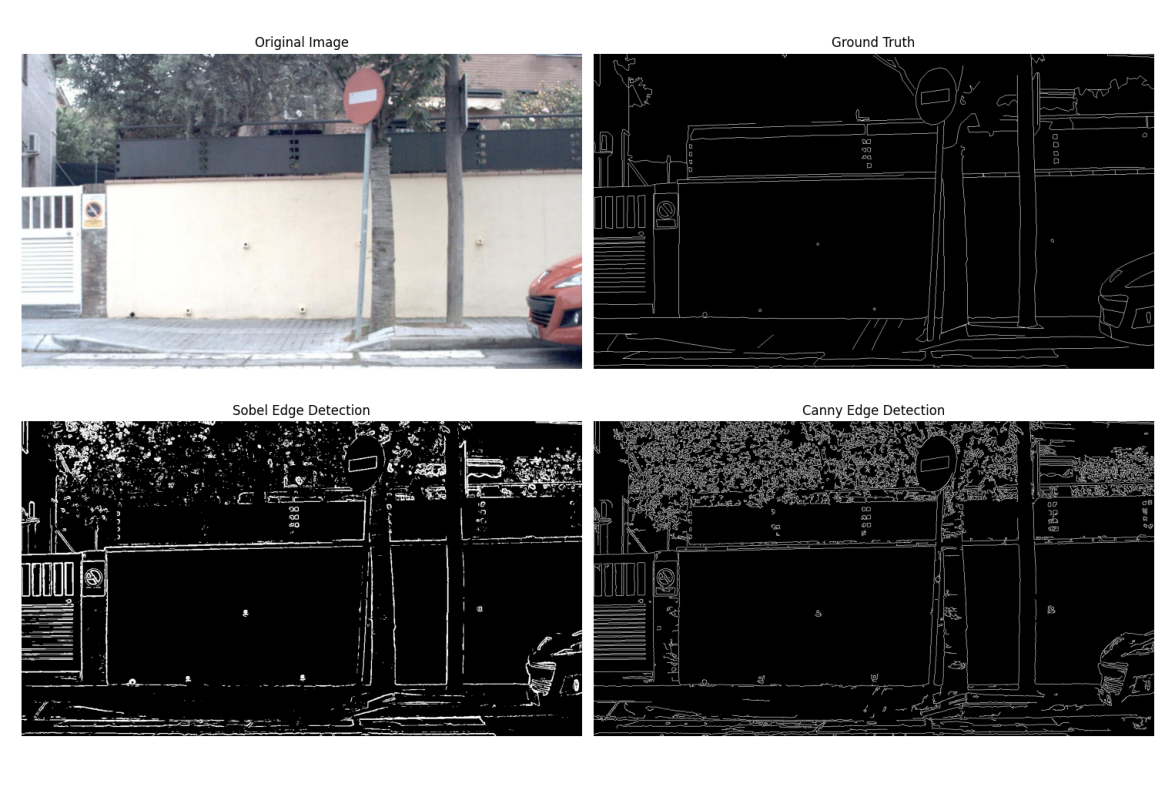

In [8]:
# Membaca gambar
img = mpimg.imread('./assets/compar/comparison_RGB_113.png')

# Menampilkan gambar
plt.figure(figsize=(20, 10)) 
plt.imshow(img)
plt.axis('off')  # Menonaktifkan sumbu
plt.show()

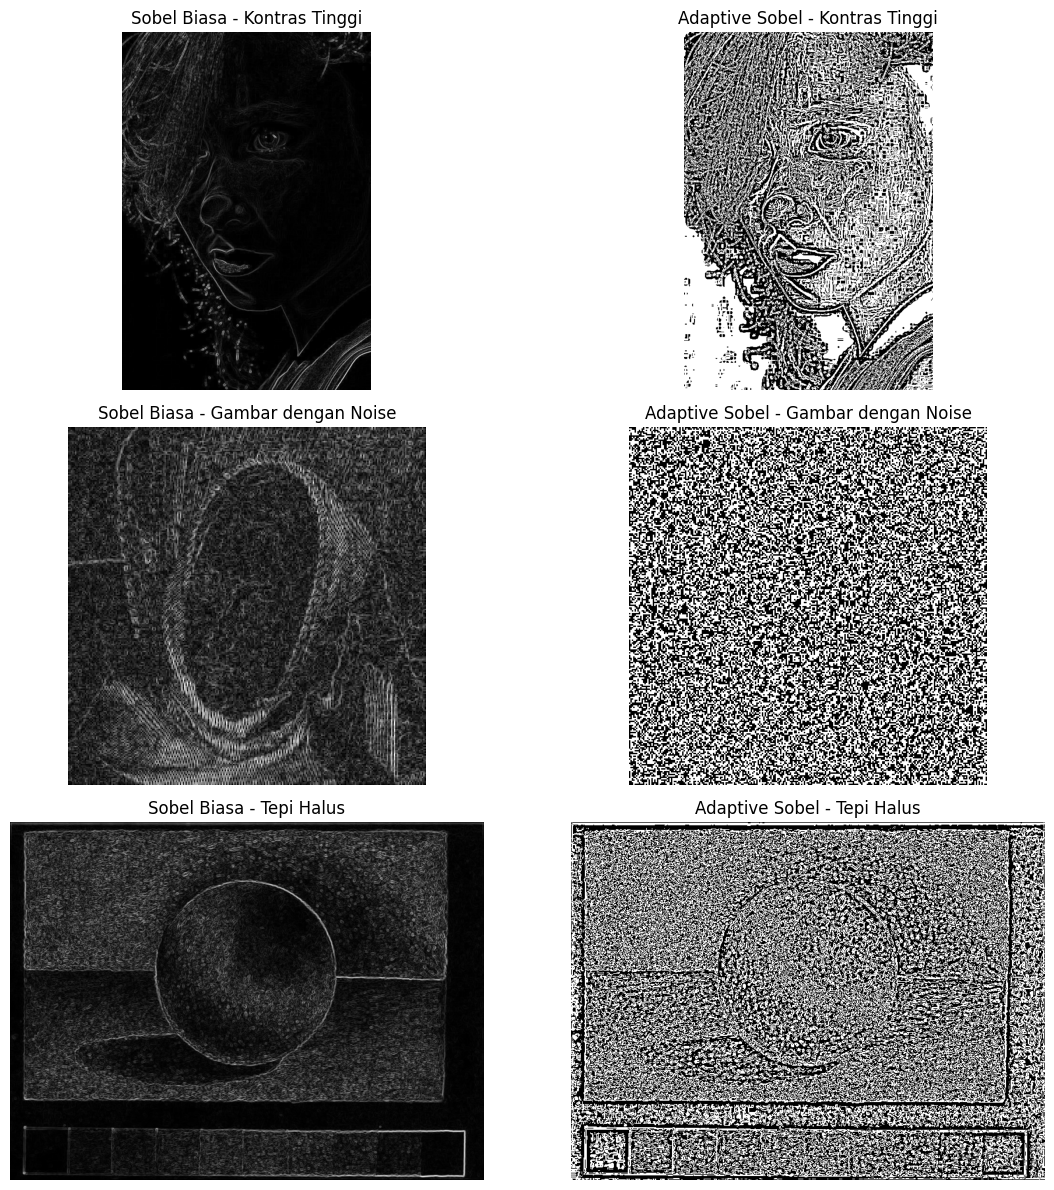

In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Fungsi untuk membaca gambar dan mengonversinya ke grayscale
def load_image(image_path):
    return cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Fungsi untuk melakukan Sobel biasa
def sobel_edge_detection(image):
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # Gradien horizontal
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)  # Gradien vertikal
    sobel_edge = cv2.magnitude(sobel_x, sobel_y)
    return sobel_edge

# Fungsi untuk melakukan Adaptive Sobel
def adaptive_sobel(image):
    # Menggunakan Sobel untuk gradien, kemudian menerapkan adaptive threshold
    sobel_edge = sobel_edge_detection(image)
    adaptive_threshold = cv2.adaptiveThreshold(
        sobel_edge.astype(np.uint8), 255, cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY, 11, 2
    )
    return adaptive_threshold

# Gambar 1: Kontras Tinggi (misalnya, gambar dengan bayangan tajam atau kontras besar)
image1 = load_image('contrast.jpeg')

# Gambar 2: Gambar dengan Noise (misalnya, gambar yang memiliki banyak gangguan visual)
image2 = load_image('noise.png')

# Gambar 3: Tepi Halus (misalnya, gambar dengan tepi kabur atau kurang jelas)
image3 = load_image('tepi.jpg')

# Apply Sobel Biasa dan Adaptive Sobel pada ketiga gambar
sobel1 = sobel_edge_detection(image1)
adaptive1 = adaptive_sobel(image1)

sobel2 = sobel_edge_detection(image2)
adaptive2 = adaptive_sobel(image2)

sobel3 = sobel_edge_detection(image3)
adaptive3 = adaptive_sobel(image3)

# Plot hasilnya untuk perbandingan
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

# Gambar 1: Kontras Tinggi
axs[0, 0].imshow(sobel1, cmap='gray')
axs[0, 0].set_title('Sobel Biasa - Kontras Tinggi')
axs[0, 0].axis('off')

axs[0, 1].imshow(adaptive1, cmap='gray')
axs[0, 1].set_title('Adaptive Sobel - Kontras Tinggi')
axs[0, 1].axis('off')

# Gambar 2: Gambar dengan Noise
axs[1, 0].imshow(sobel2, cmap='gray')
axs[1, 0].set_title('Sobel Biasa - Gambar dengan Noise')
axs[1, 0].axis('off')

axs[1, 1].imshow(adaptive2, cmap='gray')
axs[1, 1].set_title('Adaptive Sobel - Gambar dengan Noise')
axs[1, 1].axis('off')

# Gambar 3: Tepi Halus
axs[2, 0].imshow(sobel3, cmap='gray')
axs[2, 0].set_title('Sobel Biasa - Tepi Halus')
axs[2, 0].axis('off')

axs[2, 1].imshow(adaptive3, cmap='gray')
axs[2, 1].set_title('Adaptive Sobel - Tepi Halus')
axs[2, 1].axis('off')

plt.tight_layout()
plt.show()

## Last Approach



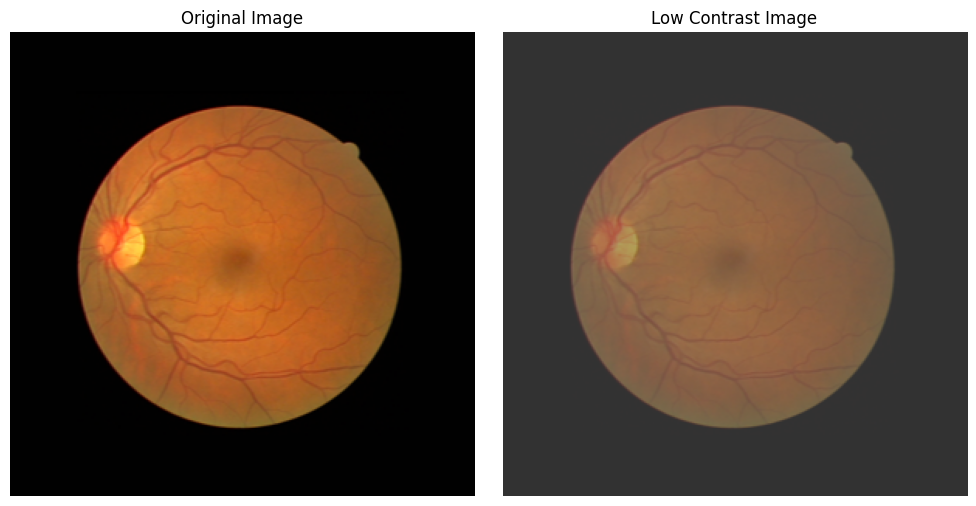

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image
img = cv2.imread('lc.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib

# Lower contrast
alpha = 0.5  # contrast control (1.0 = original, <1.0 = lower contrast)
beta = 50    # brightness control (optional, for adjustment)

low_contrast_img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)

# Visualize
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Original Image')
plt.imshow(img)
plt.axis('off')

plt.subplot(1,2,2)
plt.title('Low Contrast Image')
plt.imshow(low_contrast_img)
plt.axis('off')

plt.tight_layout()
plt.show()

In [11]:
low_contrast_bgr = cv2.cvtColor(low_contrast_img, cv2.COLOR_RGB2BGR)  # Convert back to BGR for saving
cv2.imwrite('lc_1.jpg', low_contrast_bgr)

True